In [24]:
# ===========================================
# 05A — Single Player Anomaly Visualization
# ===========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 設定
# ------------------------------
TARGET_PLAYER = "Kaoru YAMAWAKI"

BASE03 = f"/workspace/data/03/players/{TARGET_PLAYER}"
BASE02 = f"/workspace/data/02/players/{TARGET_PLAYER}"

STATIC_LABEL_PATH  = f"{BASE03}/static_labels.parquet"
DYNAMIC_LABEL_PATH = f"{BASE03}/dynamic_labels.parquet"
ACWR_PATH          = f"{BASE02}/{TARGET_PLAYER}_acwr.parquet"

print("Loading...")
df_static = pd.read_parquet(STATIC_LABEL_PATH)      # date_, iso_anomaly, iso_score, top_features
df_dynamic = pd.read_parquet(DYNAMIC_LABEL_PATH)    # date_, dyn_error, dyn_anomaly
df_acwr = pd.read_parquet(ACWR_PATH)

print(df_static.shape, df_dynamic.shape, df_acwr.shape)


Loading...
(623, 4) (536, 3) (623, 10)


In [25]:
# ------------------------------
# ACWR 整理
# ------------------------------

acwr_cols = [c for c in df_acwr.columns if "ACWR_EWMA" in c]

def acwr_flag(x):
    if pd.isna(x): return 0
    if x > 1.5 or x < 0.8: return 1
    return 0

df_acwr_use = df_acwr[["date_"] + acwr_cols].copy()
df_acwr_use = df_acwr_use.sort_values("date_")

for col in acwr_cols:
    df_acwr_use[f"{col}_flag"] = df_acwr_use[col].apply(acwr_flag)

df_acwr_use["acwr_anomaly"] = df_acwr_use[[f"{col}_flag" for col in acwr_cols]].max(axis=1)

df_acwr_use.head()


,date_,ACWR_EWMA_total_distance,ACWR_EWMA_total_player_load,ACWR_EWMA_total_distance_flag,ACWR_EWMA_total_player_load_flag,acwr_anomaly
0,2023-01-12,NaN,NaN,0,0,0
1,2023-01-13,NaN,NaN,0,0,0
2,2023-01-14,NaN,NaN,0,0,0
3,2023-01-16,NaN,NaN,0,0,0
4,2023-01-17,NaN,NaN,0,0,0


In [26]:
# ------------------------------
# 静的ラベルを日付で合わせる
# ------------------------------
df_static_full = df_acwr_use[["date_"]].merge(df_static, on="date_", how="left")
df_static_full["iso_anomaly"] = df_static_full["iso_anomaly"].fillna(0)
df_static_full["iso_score"]   = df_static_full["iso_score"].fillna(0)
df_static_full["top_features"] = df_static_full["top_features"].fillna("").astype(str)

# ------------------------------
# 動的ラベル
# ------------------------------
df_dyn_full = df_acwr_use[["date_"]].merge(df_dynamic, on="date_", how="left")
df_dyn_full = df_dyn_full.fillna(0)


In [27]:
# ------------------------------
# 統合データフレーム
# ------------------------------
df_total = (
    df_acwr_use
    .merge(df_static_full, on="date_", how="left")
    .merge(df_dyn_full,   on="date_", how="left")
    .sort_values("date_")
)

# total anomaly score
df_total["total_anomaly_score"] = (
      df_total["iso_anomaly"]
    + df_total["dyn_anomaly"]
    + df_total["acwr_anomaly"]
)

# 強異常（説明しやすい）
df_total["strong_anomaly"] = (df_total["total_anomaly_score"] >= 2).astype(int)

df_total.head()


,date_,ACWR_EWMA_total_distance,ACWR_EWMA_total_player_load,ACWR_EWMA_total_distance_flag,ACWR_EWMA_total_player_load_flag,acwr_anomaly,iso_score,iso_anomaly,top_features,dyn_error,dyn_anomaly,total_anomaly_score,strong_anomaly
0,2023-01-12,NaN,NaN,0,0,0,0.032333,0,,0.0,0.0,0.0,0
1,2023-01-13,NaN,NaN,0,0,0,0.111313,0,,0.0,0.0,0.0,0
2,2023-01-14,NaN,NaN,0,0,0,0.014959,0,,0.0,0.0,0.0,0
3,2023-01-16,NaN,NaN,0,0,0,0.050255,0,,0.0,0.0,0.0,0
4,2023-01-17,NaN,NaN,0,0,0,0.134306,0,,0.0,0.0,0.0,0


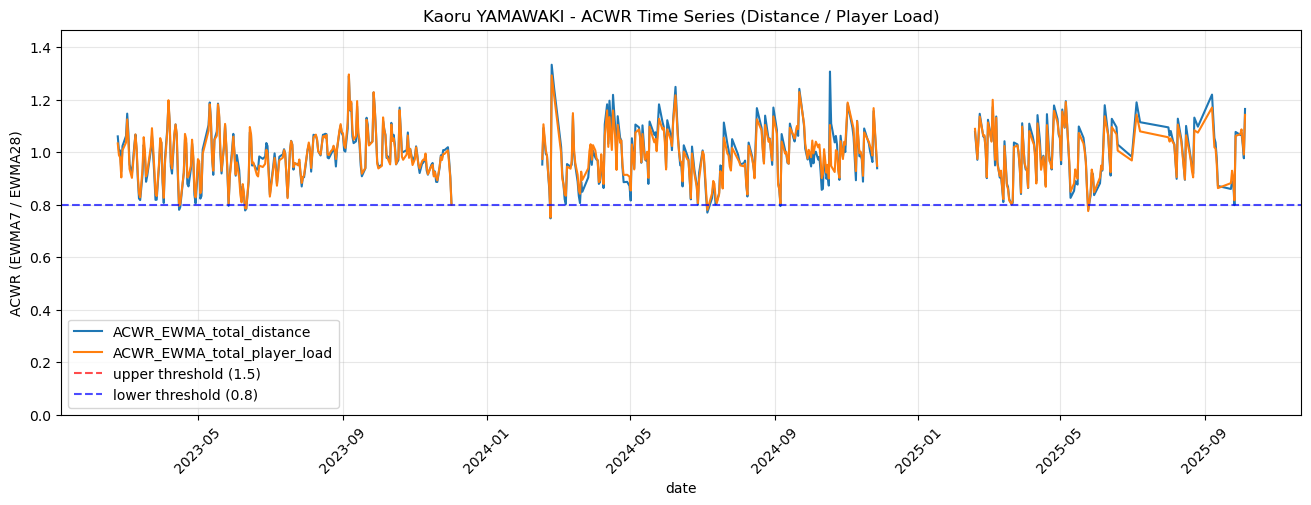

In [32]:
# ===========================================
# ACWR 時系列プロット（距離 & ロード）
# ===========================================

plt.figure(figsize=(16,5))

for col in acwr_cols:
    plt.plot(df_acwr_use["date_"], df_acwr_use[col], label=col)

# しきい値ライン（可変）
plt.axhline(1.5, color="red", linestyle="--", alpha=0.7, label="upper threshold (1.5)")
plt.axhline(0.8, color="blue", linestyle="--", alpha=0.7, label="lower threshold (0.8)")

plt.title(f"{TARGET_PLAYER} - ACWR Time Series (Distance / Player Load)")
plt.xlabel("date")
plt.ylabel("ACWR (EWMA7 / EWMA28)")
plt.xticks(rotation=45)
plt.ylim(0, max(df_acwr_use[acwr_cols].max()) * 1.1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
